In [192]:
# 모듈 로딩
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras, requests, warnings, cv2, os, re

from keras import layers
from keras.utils import plot_model
from keras.models import Sequential, save_model, load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array

warnings.filterwarnings('ignore')

# [1] 데이터 로딩 및 확인

### [1-1] 고화질 이미지 로딩

In [193]:
SIZE = 256
high_img = []
path = './data/HR'
files = os.listdir(path)
for i in files:
    img = cv2.imread(path + '/' + i, 1)
    # cv.2.imread는 BGR 형식으로 불러오기 때문에 RGB형식으로 재배열
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 이미지 리사이징
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    high_img.append(img_to_array(img))

### [1-2] 저화질 이미지 로딩

In [194]:
low_img = []
path = './data/LR'
files = os.listdir(path)
for i in files:
    img = cv2.imread(path + '/' + i, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 이미지 리사이징
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    low_img.append(img_to_array(img))

### [1-3] 고화질/저화질 이미지 비교

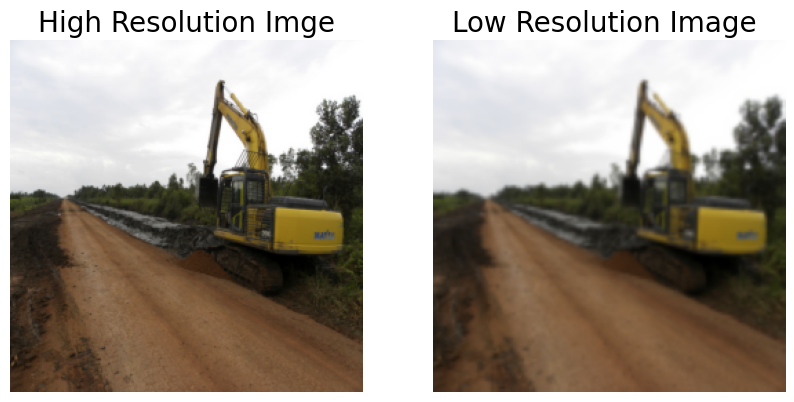

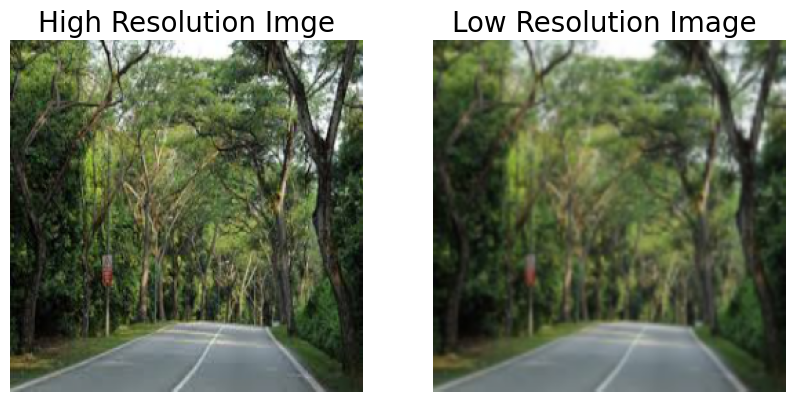

In [195]:
for i in range(2):
    a = np.random.randint(0, 100)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('High Resolution Imge', fontsize=20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Low Resolution Image ', fontsize=20)
    plt.imshow(low_img[a])
    plt.axis('off')

# [2] 트레인/테스트/검증용 데이터 분리

In [196]:
train_high_image = high_img[:550]
train_low_image = low_img[:550]
train_high_image = np.reshape(train_high_image, (-1, SIZE, SIZE, 3))
train_low_image = np.reshape(train_low_image, (-1, SIZE, SIZE, 3))

validation_high_image = high_img[550:670]
validation_low_image = low_img[550:670]
validation_high_image = np.reshape(validation_high_image, (-1, SIZE, SIZE, 3))
validation_low_image = np.reshape(validation_low_image, (-1, SIZE, SIZE, 3))

test_high_image = high_img[670:]
test_low_image = low_img[670:]
test_high_image = np.reshape(test_high_image, (-1, SIZE, SIZE, 3))
test_low_image = np.reshape(test_low_image, (-1, SIZE, SIZE, 3))

print("train_high_image.shape :", train_high_image.shape)
print("test_high_image.shape :", test_high_image.shape)
print("validation_high_image.shape :", validation_high_image.shape)

train_high_image.shape : (550, 256, 256, 3)
test_high_image.shape : (15, 256, 256, 3)
validation_high_image.shape : (120, 256, 256, 3)


# [3] CNN 모델 구성 및 생성

### [3-1] 모델 구성

In [197]:
def down(node, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(node, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(node, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(node, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


def model():
    # input 레이어
    inputs = layers.Input(shape=[SIZE, SIZE, 3])
    # 특성 압축
    d1 = down(512, (3, 3), False)(inputs)
    d2 = down(256, (3, 3), False)(d1)
    d3 = down(256, (3, 3), True)(d2)
    d4 = down(128, (3, 3), True)(d3)
    d5 = down(128, (3, 3), True)(d4)
    # 업샘플링
    u1 = up(128, (3, 3), False)(d5)
    u1 = layers.concatenate([u1, d4])
    u2 = up(128, (3, 3), False)(u1)
    u2 = layers.concatenate([u2, d3])
    u3 = up(256, (3, 3), False)(u2)
    u3 = layers.concatenate([u3, d2])
    u4 = up(512, (3, 3), False)(u3)
    u4 = layers.concatenate([u4, d1])
    u5 = up(3, (3, 3), False)(u4)
    u5 = layers.concatenate([u5, inputs])
    output = layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

### [3-2] 모델 생성 및 구조확인

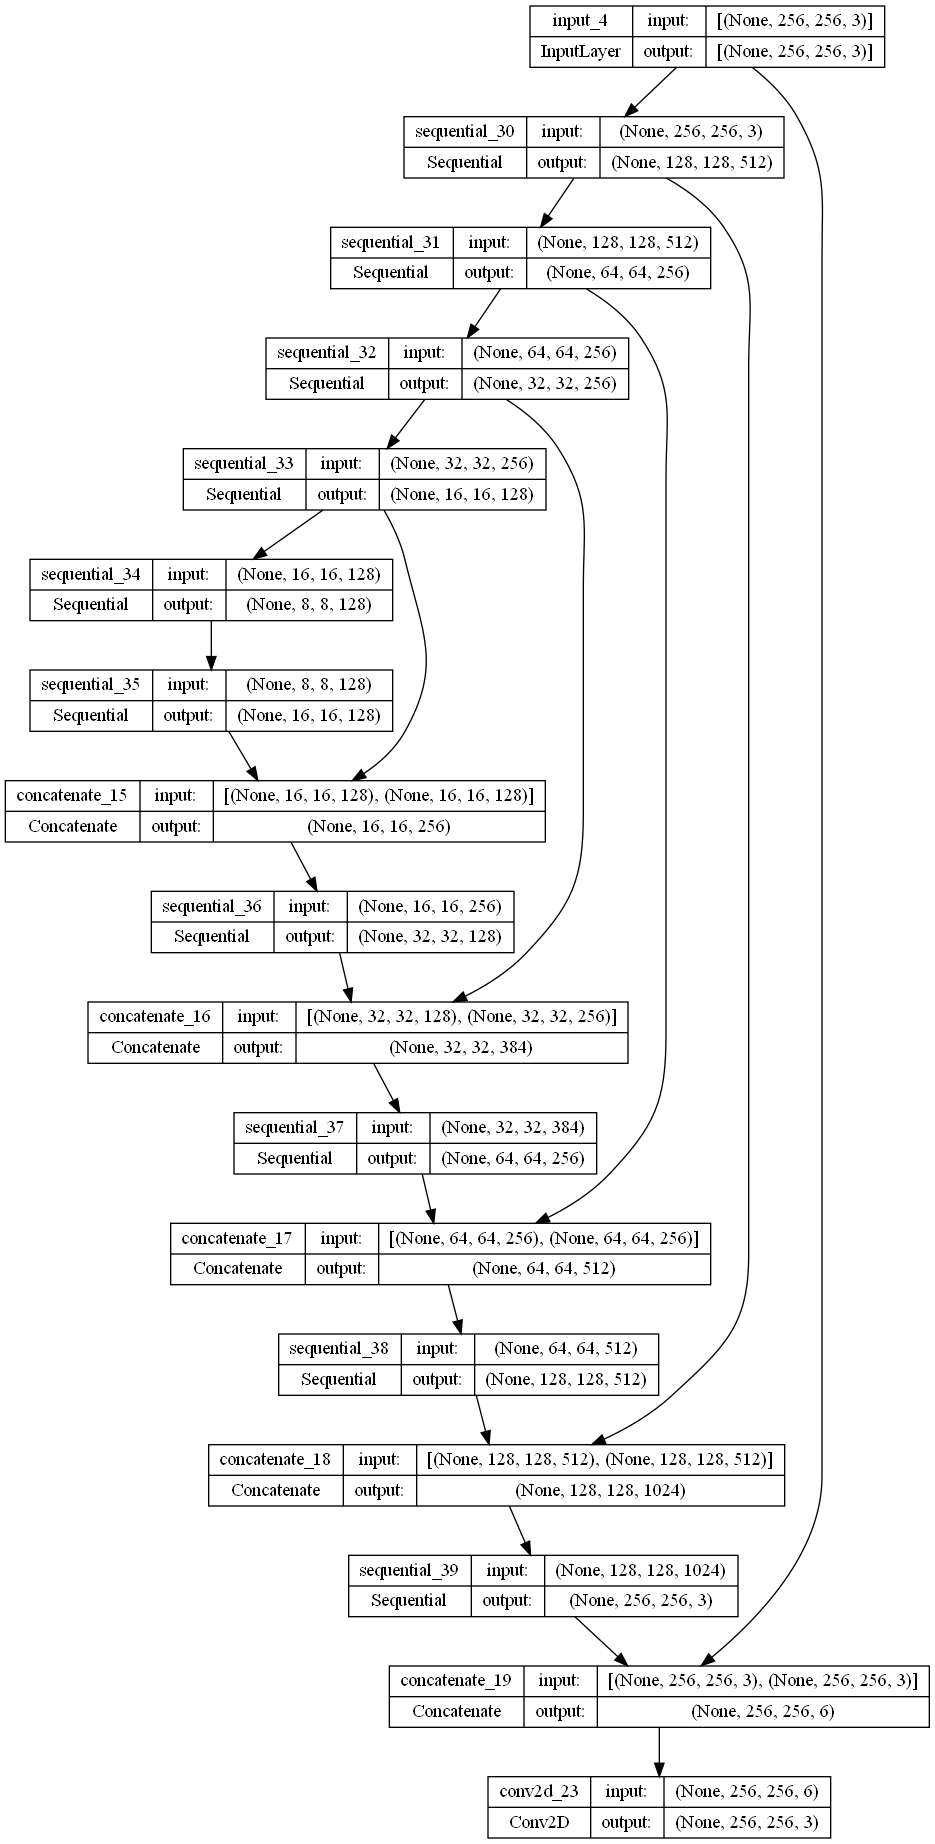

In [198]:
model = model()
plot_model(model, to_file='super_res.png', show_shapes=True)

### [3-3] CNN 모델 학습

In [ ]:
# model.compile(optimizer='Adam', loss='mean_absolute_error', metrics='acc')
model.fit(train_low_image, train_high_image, epochs=30, batch_size=1,
          validation_data=(validation_low_image, validation_high_image))

Epoch 1/30
 70/550 [==>...........................] - ETA: 5:42 - loss: 0.0336 - acc: 0.7299

In [177]:
# 모델 저장
M_FILE = r'CNNModel.h5'
save_model(model, M_FILE)

# [4] 예측결과 확인

### [4-1] 테스트 데이터로 확인

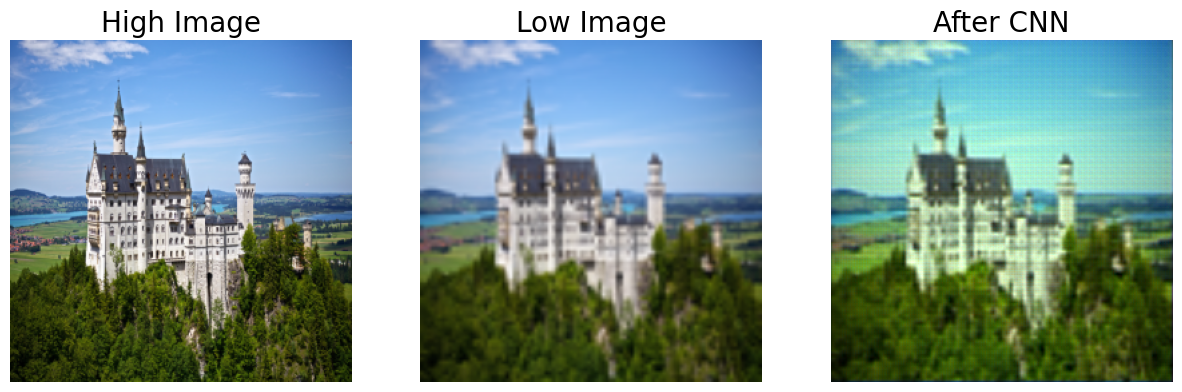

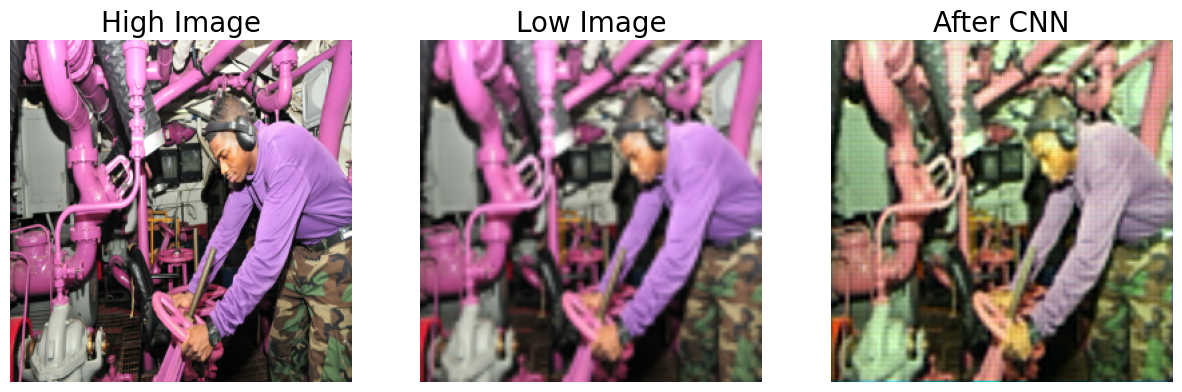

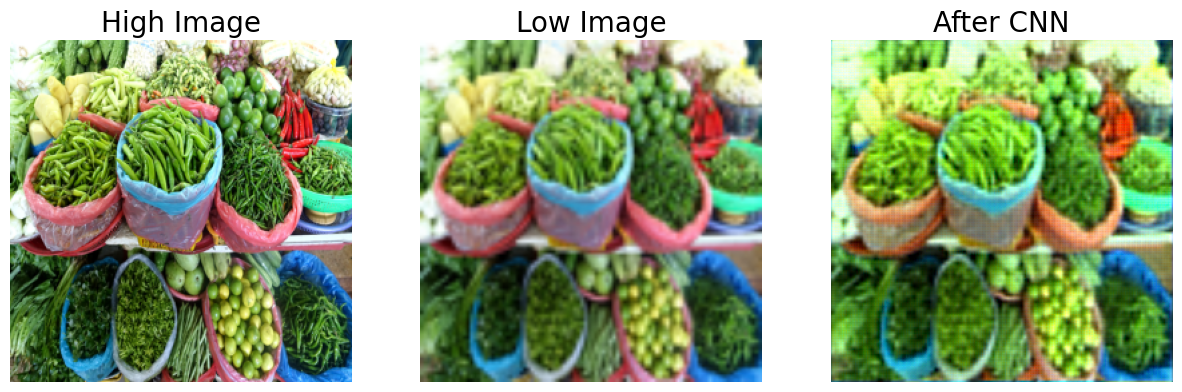

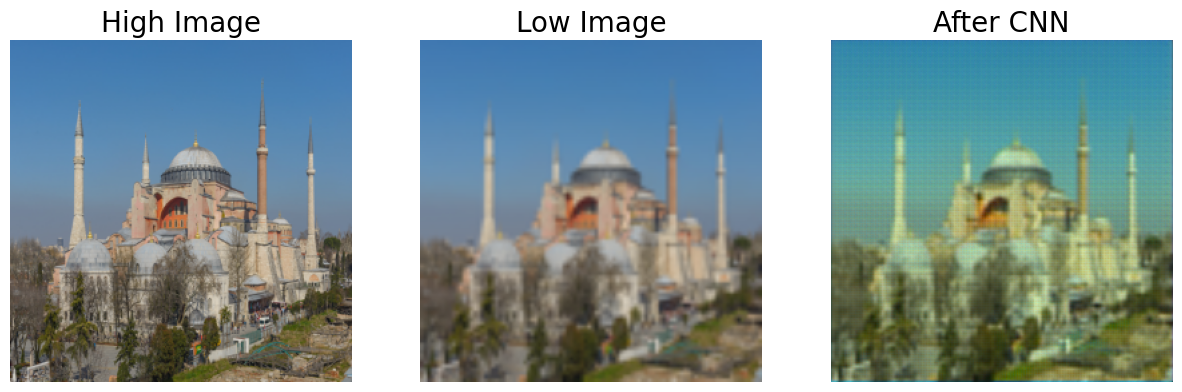

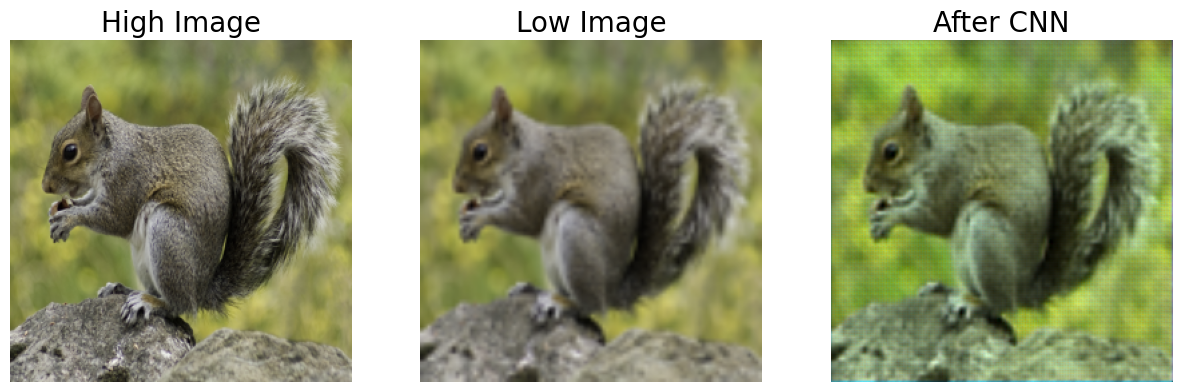

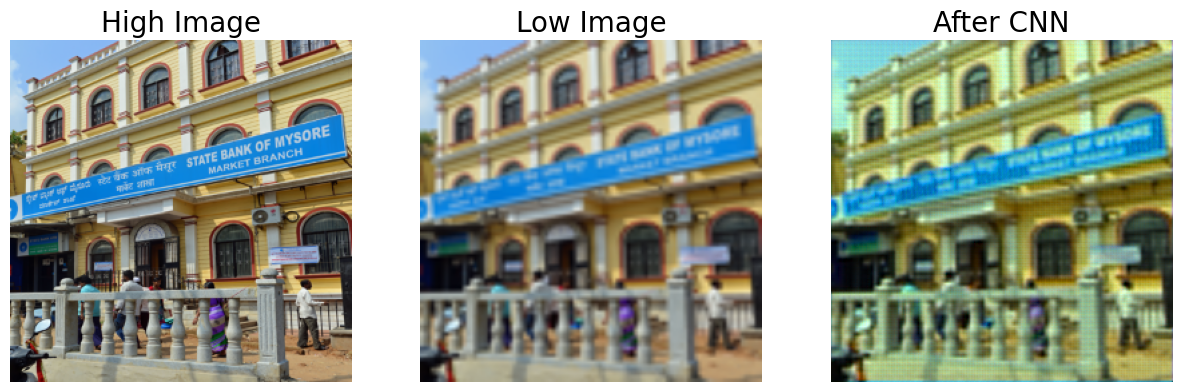

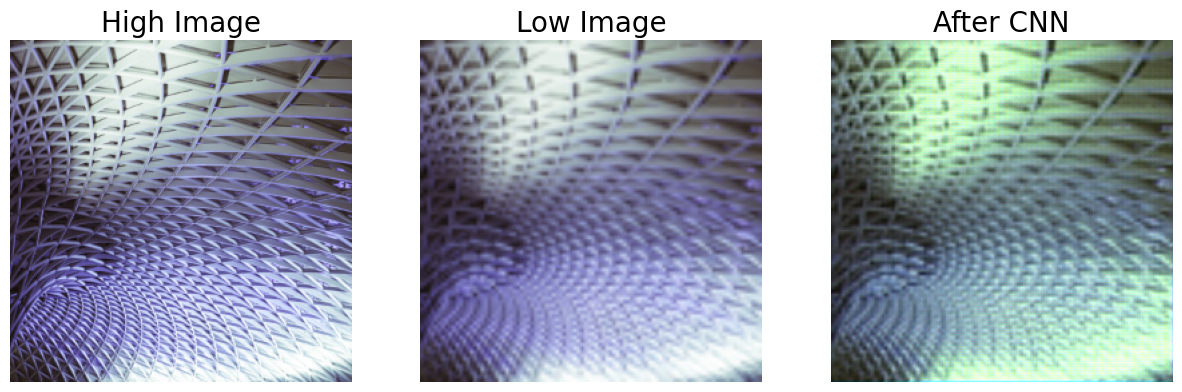

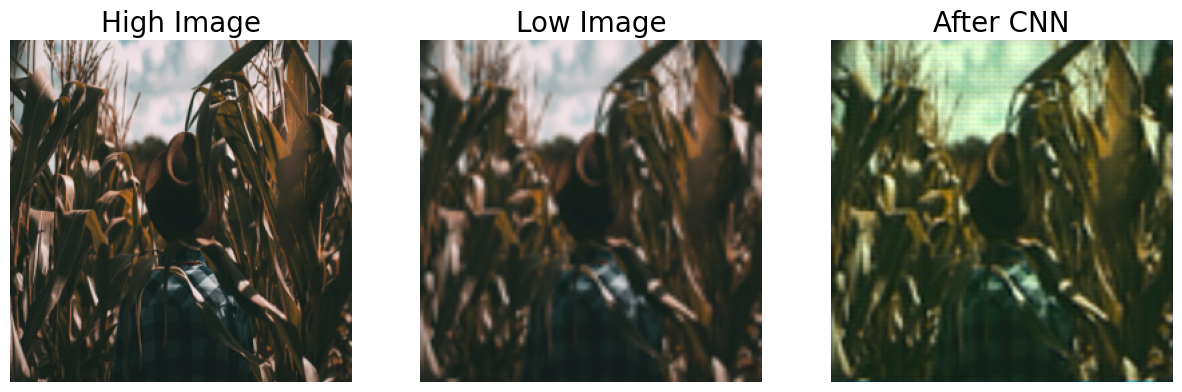

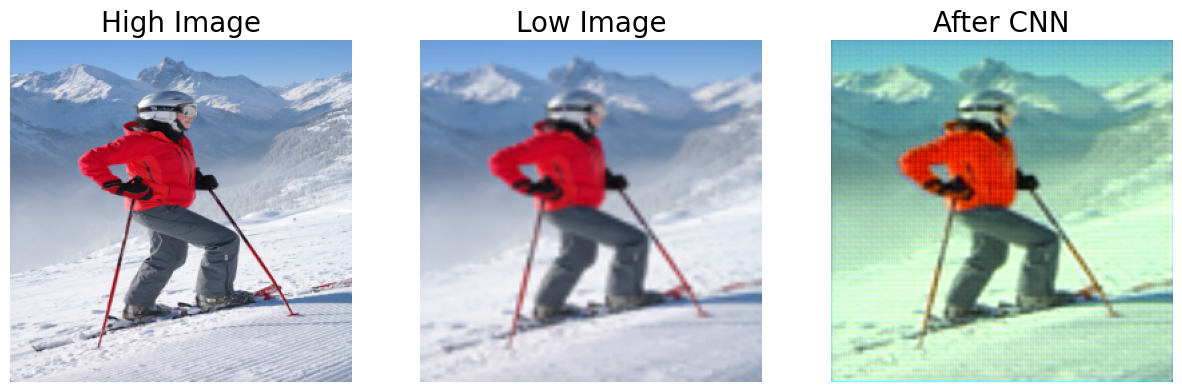

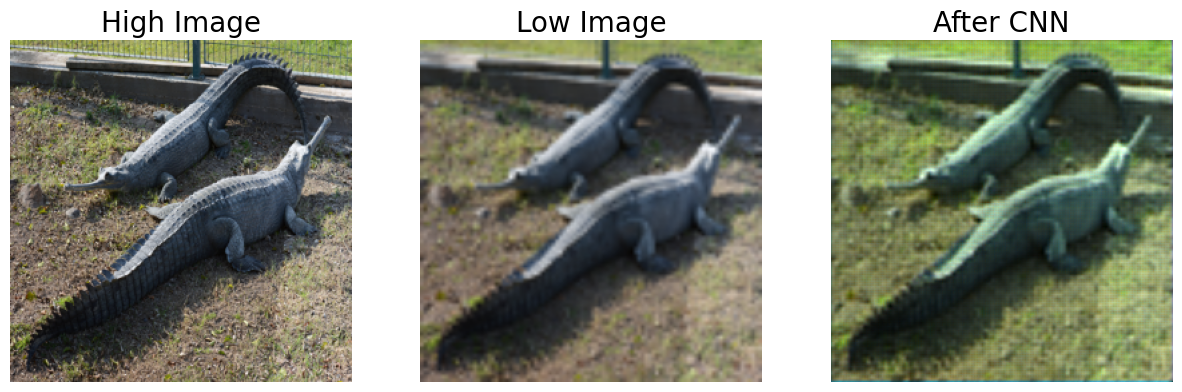

In [200]:
def plot_images(high, low, pre_cnn):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High Image', fontsize=20)
    plt.axis('off')
    plt.imshow(high)
    plt.subplot(1, 3, 2)
    plt.title('Low Image', fontsize=20)
    plt.axis('off')
    plt.imshow(low)
    plt.subplot(1, 3, 3)
    plt.title('After CNN', fontsize=20)
    plt.axis('off')
    plt.imshow(pre_cnn)


for i in range(0, 10):
    pre = model.predict(test_low_image[i].reshape(1, SIZE, SIZE, 3), verbose=False)
    pre = np.clip(pre, 0, 1)
    plot_images(test_high_image[i], test_low_image[i], pre.reshape(SIZE, SIZE, 3))

### [4-2] 검증용 데이터로 확인

In [ ]:
for i in range(0, 10):
    pre = model.predict(validation_low_image[i].reshape(1, SIZE, SIZE, 3), verbose=False)
    pre = np.clip(pre, 0, 1)
    plot_images(validation_high_image[i], validation_low_image[i], pre.reshape(SIZE, SIZE, 3))